In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
%matplotlib inline

In [2]:
from nmt_run import *

translating es to en
callhome es-en configuration
--------------------------------------------------
loading info_dict from=./mfcc_out/info.dict


 41%|████▏     | 57246/138708 [00:00<00:00, 572450.99it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 138708/138708 [00:00<00:00, 613186.00it/s]


--------------------------------------------------
saving info dict in: ./mfcc_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=20, width of each bucket=64
index | width | num   
    0 |     0 |     75
    1 |    64 |    733
    2 |   128 |    598
    3 |   192 |    398
    4 |   256 |    346
    5 |   320 |    281
    6 |   384 |    220
    7 |   448 |    200
    8 |   512 |    150
    9 |   576 |    148
   10 |   640 |    145
   11 |   704 |    116
   12 |   768 |     97
   13 |   832 |    103
   14 |   896 |     91
   15 |   960 |     57
   16 |  1024 |     52
   17 |  1088 |     55
   18 |  1152 |     34
   19 |  1216 |     78
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=20, width of each bucket=64
index | width | num   
    0 |     0 |     54
    1 |    64 |    591
    2 |   128 |    548
    3 |   192 |    463
    4 |   256

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_t2t/seq2seq_sen-138819_hwy2-dec2_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000001_32_32_2_2_2DCNN_BN_LN_enc-2_35.model
loading ...
finished loading ..


In [4]:
log_dev_fil_name

'fsh_t2t/dev_sen-138819_hwy2-dec2_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000001_32_32_2_2_2DCNN_BN_LN_enc-2.log'

In [5]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=5).transpose()

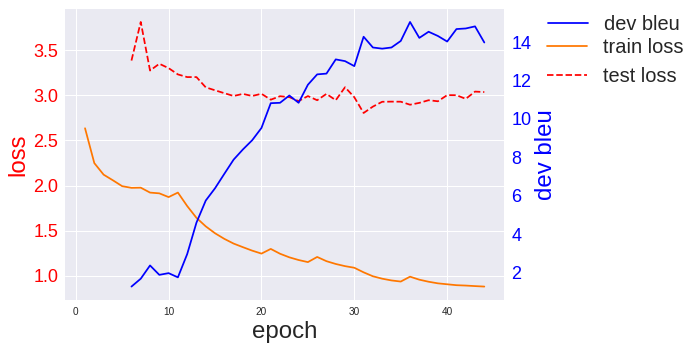

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [7]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [8]:
cat_speech_path = os.path.join(out_path, key)

In [9]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3899 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 36


b=8,l=2.71,avg=2.92: 100%|██████████| 3899/3899 [02:11<00:00, 27.40it/s] 

********** dev mean loss=2.9250
-
--------------------------------------------------------------------------------


In [10]:
display_words(m_dict, v_dict, pred_sents[-50:], utts[-50:], dec_key)

Utterance: 20051018_210220_279_fsp-A-59
+---------+---------------------------------------------------+
| es ref  | y entonces yo le dije a mi esposo nunca jamás     |
|         | nunca                                             |
+---------+---------------------------------------------------+
| en ref  | and then i told my husband never again never      |
+---------+---------------------------------------------------+
| en pred | and then i had my husband never never never never |
|         | never never never never never never never never   |
|         | never never never never never never never never   |
|         | never never never never never never never never   |
|         | never never never neve                            |
+---------+---------------------------------------------------+
Utterance: 20051009_182032_217_fsp-A-83
+---------+----------------------------------------------------+
| es ref  | que no tiene nada que ver con dios ni nada de eso  |
|         | ah uno cua

In [11]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)
print("bleu score = {0:.2f}%".format(corpus_bleu(r, h) * 100))

bleu score = 14.04%
